In [1]:
%matplotlib inline

Copied/adapted this notebook from: <a href=http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py> PyTorch: Training a Classifier on CIFAR-10</a>
Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CBAS-36 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CBAS-36

Using ``torchvision``, it’s extremely easy to load CBAS-36.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
from torch.utils.data.sampler import Sampler
class MySampler(Sampler):
    def __init__(self, data_source):
        self.data_source = data_source
        self.random_list = None

    def __iter__(self):
        self.random_list = torch.randperm(len(self.data_source)).tolist()
        return iter(self.random_list)
    
    def get_idx(self):
        return self.random_list

    def __len__(self):
        return len(self.data_source)

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

trainset = torchvision.datasets.ImageFolder(root='images/cbas34_train', transform=transform)

# get index for curriculum sampling
# id2idx = {}
# for i,img in enumerate(trainset.imgs):
#     img_id_str = img[0].split('/')[4].split('.')[0]
#     id2idx[img_id_str] = i
    

my_sampler = MySampler(trainset) #TODO sample with replacement!
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, sampler=my_sampler, num_workers=4)

testset = torchvision.datasets.ImageFolder(root='images/cbas34_val', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = trainset.classes

Let us show some of the training images, for fun.



 sink horse  boat airplane


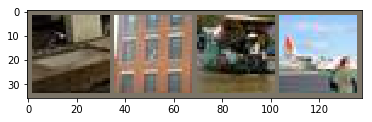

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(tensor):
    for t, m, s in zip(tensor, IMAGENET_MEAN, IMAGENET_STD):
            t.mul_(s).add_(m)     # unnormalize
    npimg = tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



<img src=https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig4/AS:552880910368768@1508828489761/Architecture-of-simplified-convolutional-neural-network.ppm>

In [8]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 34)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out




3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [9]:
import torch.optim as optim

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [10]:
def normal_weights(losses, mu=None):
    mu, var = mu if mu else np.mean(losses), np.var(losses)
    return (1/(np.sqrt(np.pi*2*var)))*np.exp(-((losses-mu)**2)/(2*var))

In [11]:
def find_curriculum(num_epochs, loader, net, criterion, optimizer):
    culmulative_orderings = None
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        orderings = []
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            # get the inputs
            inputs, labels = data
            
            try:
                numpy_labels = labels.numpy()
            except:
                numpy_labels = labels.data.numpy()
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            if epoch == num_epochs-1:
                try:
                    numpy_outputs = outputs.numpy()
                except:
                    numpy_outputs = outputs.data.numpy()
                log_probs = -np.log(np.exp(numpy_outputs) 
                                    / np.reshape(np.sum(np.exp(numpy_outputs), axis=1), (numpy_labels.shape[0], 1)))
                orderings += log_probs[:, numpy_labels].tolist()[0]
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.data[0]
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        idx = np.argsort(np.array(my_sampler.get_idx()))
        if epoch == num_epochs-1:
            culmulative_orderings = np.array(orderings)[idx]   
        elif False:
            culmulative_orderings += np.array(orderings)[idx]
            
    return culmulative_orderings

net = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 4
curr = find_curriculum(num_epochs, trainloader, net, criterion, optimizer)

[1,  2000] loss: 3.470
[1,  4000] loss: 3.318
[1,  6000] loss: 3.224
[1,  8000] loss: 3.134
[1, 10000] loss: 3.102
[1, 12000] loss: 3.060
[2,  2000] loss: 3.005
[2,  4000] loss: 3.000
[2,  6000] loss: 3.000
[2,  8000] loss: 2.961
[2, 10000] loss: 2.941
[2, 12000] loss: 2.927
[3,  2000] loss: 2.888
[3,  4000] loss: 2.880
[3,  6000] loss: 2.899
[3,  8000] loss: 2.879
[3, 10000] loss: 2.878
[3, 12000] loss: 2.874
[4,  2000] loss: 2.799
[4,  4000] loss: 2.832
[4,  6000] loss: 2.809
[4,  8000] loss: 2.841
[4, 10000] loss: 2.840
[4, 12000] loss: 2.818


In [12]:
def adjust_lr(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] /= 2

In [13]:
def train_curriculum(loader, net, criterion, optimizer):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # get the inputs
        inputs, labels = data
            
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('%5d loss: %.3f' % (i + 1, running_loss / 2000))
            running_loss = 0.0

from torch.utils.data.sampler import WeightedRandomSampler as W_Sampler

curr_net = LeNet()
curr_criterion = nn.CrossEntropyLoss()
curr_optimizer = optim.SGD(curr_net.parameters(), lr=0.001, momentum=0.9)
num_samples = curr.shape[0]

epoch_counter = 0
for deviation in np.arange(-2.0, 2, 1):
    epoch_counter += 1
    print("epoch #%d" % epoch_counter)
    weights = normal_weights(curr, np.mean(curr) + deviation*np.std(curr))
    weights = weights/ np.sum(weights)
    sampler = W_Sampler(weights, num_samples, replacement=True)
    curriculum_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, sampler=sampler, num_workers=4)
    train_curriculum(curriculum_loader, curr_net, curr_criterion, curr_optimizer)
    
print('Finished Training')

epoch #1
 2000 loss: 3.440
 4000 loss: 3.217
 6000 loss: 3.048
 8000 loss: 2.934
10000 loss: 2.852
12000 loss: 2.797
epoch #2
 2000 loss: 2.971
 4000 loss: 2.951
 6000 loss: 2.907
 8000 loss: 2.884
10000 loss: 2.856
12000 loss: 2.854
epoch #3
 2000 loss: 2.902
 4000 loss: 2.911
 6000 loss: 2.915
 8000 loss: 2.892
10000 loss: 2.869
12000 loss: 2.875
epoch #4
 2000 loss: 2.838
 4000 loss: 2.819
 6000 loss: 2.812
 8000 loss: 2.774
10000 loss: 2.800
12000 loss: 2.799
Finished Training


In [14]:
from torch import Tensor

class MyWeightedSampler(Sampler):
   
    def __init__(self, weights, num_samples, replacement=True):
        self.weights = torch.DoubleTensor(weights)
        self.num_samples = num_samples
        self.replacement = replacement
        self.random_list = None

    def __iter__(self):
        ret = torch.multinomial(self.weights, self.num_samples, self.replacement)
        self.random_list = ret.numpy().tolist()
        return iter(ret)

    def get_idx(self):
        return self.random_list
    
    def __len__(self):
        return self.num_samples

In [37]:
def real_time_curriculum(sampler, loader, net, criterion, optimizer):
    orderings = []
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # get the inputs
        inputs, labels = data

        try:
            numpy_labels = labels.numpy()
        except:
            numpy_labels = labels.data.numpy()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        try:
            numpy_outputs = outputs.numpy()
        except:
            numpy_outputs = outputs.data.numpy()
        log_probs = -np.log(np.exp(numpy_outputs) 
                            / np.reshape(np.sum(np.exp(numpy_outputs), axis=1), (numpy_labels.shape[0], 1)))
        orderings += log_probs[:, numpy_labels].tolist()[0]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('%5d loss: %.3f' %
                  (i + 1, running_loss / 2000))
            running_loss = 0.0
    idx = np.argsort(np.array(sampler.get_idx()))
    culmulative_orderings = np.array(orderings)[idx] 
    return culmulative_orderings

real_time_net = LeNet()
real_time_criterion = nn.CrossEntropyLoss()
real_time_optimizer = optim.SGD(real_time_net.parameters(), lr=0.001, momentum=0.9)

print("epoch #1")
real_time_curr = \
    real_time_curriculum(my_sampler, trainloader, real_time_net, real_time_criterion, real_time_optimizer)
#adjust_lr(real_time_optimizer)
epoch = 1

for deviation in np.arange(-1.0, 2, 1):
    epoch += 1
    print("epoch #%d" % epoch)
    weights = normal_weights(real_time_curr, np.mean(real_time_curr) + deviation*np.std(real_time_curr))
    weights = weights / np.sum(weights)
    sampler = MyWeightedSampler(weights, num_samples, replacement=True)
    real_time_curriculum_loader = \
    torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, sampler=sampler, num_workers=4)
    real_time_curr = \
    real_time_curriculum(sampler, real_time_curriculum_loader, real_time_net, real_time_criterion, real_time_optimizer)
#     if epoch % 3 == 0:
#         adjust_lr(real_time_optimizer)

epoch #1
 2000 loss: 3.480
 4000 loss: 3.326
 6000 loss: 3.246
 8000 loss: 3.160
10000 loss: 3.119
12000 loss: 3.080
epoch #2
 2000 loss: 3.036
 4000 loss: 2.978
 6000 loss: 2.956
 8000 loss: 2.956
10000 loss: 2.913
12000 loss: 2.886
epoch #3
 2000 loss: 2.894
 4000 loss: 2.883
 6000 loss: 2.875
 8000 loss: 2.855
10000 loss: 2.851
12000 loss: 2.855
epoch #4
 2000 loss: 2.710
 4000 loss: 2.709
 6000 loss: 2.691
 8000 loss: 2.654
10000 loss: 2.630
12000 loss: 2.615


5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:  airplane airplane airplane airplane


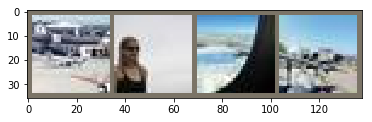

In [38]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [39]:
outputs = net(Variable(images))
curr_outputs = curr_net(Variable(images))
real_time_outputs = real_time_net(Variable(images))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [40]:
_, predicted = torch.max(outputs.data, 1)

print('(Non-curriculum) Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

_, predicted = torch.max(curr_outputs.data, 1)

print('(Curriculum) Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

_, predicted = torch.max(real_time_outputs.data, 1)

print('(Real Time Curriculum) Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

(Non-curriculum) Predicted:  truck  kite surfboard airplane
(Curriculum) Predicted:  truck tennisracket clock trafficlight
(Real Time Curriculum) Predicted:  truck  kite  kite airplane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [41]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('(Non-curriculum) Accuracy of the network on the 3744 test images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0
for data in testloader:
    images, labels = data
    curr_outputs = curr_net(Variable(images))
    _, predicted = torch.max(curr_outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('(Curriculum) Accuracy of the network on the 3744 test images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0
for data in testloader:
    images, labels = data
    real_time_outputs = real_time_net(Variable(images))
    _, predicted = torch.max(real_time_outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('(Real Time Curriculum) Accuracy of the network on the 3744 test images: %d %%' % (
    100 * correct / total))

(Non-curriculum) Accuracy of the network on the 3744 test images: 21 %
(Curriculum) Accuracy of the network on the 3744 test images: 19 %
(Real Time Curriculum) Accuracy of the network on the 3744 test images: 20 %


That looks waaay better than chance, which is 2.7% accuracy (randomly picking
a class out of 36 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [20]:
class_correct = list(0. for i in range(34))
class_total = list(0. for i in range(34))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(34):
    print('(Non-curriculum) Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
class_correct = list(0. for i in range(34))
class_total = list(0. for i in range(34))
for data in testloader:
    images, labels = data
    curr_outputs = curr_net(Variable(images))
    _, predicted = torch.max(curr_outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(34):
    print('(Curriculum) Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
class_correct = list(0. for i in range(34))
class_total = list(0. for i in range(34))
for data in testloader:
    images, labels = data
    real_time_outputs = real_time_net(Variable(images))
    _, predicted = torch.max(real_time_outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(34):
    print('(Real Time Curriculum) Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

(Non-curriculum) Accuracy of airplane : 45 %
(Non-curriculum) Accuracy of backpack : 15 %
(Non-curriculum) Accuracy of banana : 56 %
(Non-curriculum) Accuracy of bench : 14 %
(Non-curriculum) Accuracy of bicycle : 26 %
(Non-curriculum) Accuracy of  bird :  7 %
(Non-curriculum) Accuracy of  boat : 21 %
(Non-curriculum) Accuracy of  book : 22 %
(Non-curriculum) Accuracy of bottle :  5 %
(Non-curriculum) Accuracy of  bowl :  0 %
(Non-curriculum) Accuracy of   car :  5 %
(Non-curriculum) Accuracy of carrot : 70 %
(Non-curriculum) Accuracy of chair :  8 %
(Non-curriculum) Accuracy of clock : 36 %
(Non-curriculum) Accuracy of   cow : 23 %
(Non-curriculum) Accuracy of   cup :  3 %
(Non-curriculum) Accuracy of donut : 33 %
(Non-curriculum) Accuracy of  fork :  8 %
(Non-curriculum) Accuracy of handbag :  5 %
(Non-curriculum) Accuracy of horse : 13 %
(Non-curriculum) Accuracy of  kite : 37 %
(Non-curriculum) Accuracy of knife : 11 %
(Non-curriculum) Accuracy of person :  1 %
(Non-curriculum) Acc

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.
This will recursively go over all modules and convert their parameters and
buffers to CUDA tensors:

.. code:: python

    net.cuda()


Remember that you will have to send the inputs and targets at every step
to the GPU too:

::

        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.
